# SDDP and newsvendor


In [2]:
using Distributions, JuMP, Gurobi, Plots, ProgressMeter, Random
gurobi_env = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-03-16


Gurobi.Env(Ptr{Nothing} @0x000000000452d130, false, 0)

In [3]:
p = 1.0 #day ahead price
q = 2.0 #same day price

#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];

#condicion inicial de stock
x0=0.0;

## Stochastic Decomposition Alternative 2

Elijo los puntos de exploración al azar y no resolviendo el first stage.

In [8]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);
objective_values = Array{Float64}(undef,0);
explored_states = Array{Float64}(undef,0);
duals = Array{Float64}(undef,0);

#condicion inicial de stock
x0=0.0;

In [9]:
anim=Animation()

@showprogress 1 "Computing..." for l=1:200
 
    #=
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    cut_constraints = [];
    for k=1:length(cuts)
        cut=cuts[k]
        c=@constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
        push!(cut_constraints,c);
    end

    fix_x = @constraint(model,stock==x0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    #purge cuts!
    #multipliers = [dual(c) for c in cut_constraints];
    #idx = filter(k->multipliers[k]!=0,(1:length(cuts)));
    #cuts = cuts[idx];

    #if l>40
    #    cuts = cuts[end-19:end]
    #end

    x=value(stock)+value(reserve);
    =#
    
    x=rand(DiscreteUniform(0,100));
    push!(explored_states,x)

    #resuelvo para un ruido en el segundo paso y agrego un corte
    demand=rand(DiscreteUniform(0,100));
    push!(noises,demand)


    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,shortage>=0);
    @variable(model,stock_in>=0);

    @variable(model,stock_out>=0);

    @constraint(model,stock_in-demand+shortage==stock_out);

    fix_x = @constraint(model,x==stock_in);

    @objective(model,Min,q*shortage);

    optimize!(model)

    beta = objective_value(model);

    push!(objective_values,beta)

    #cambio el signo del multiplicador por que es >= en la constraint
    lambda = dual(fix_x)

    push!(duals,lambda)


    ##problema auxiliar para hallar el beta estimado de los cortes anteriores.
    aux = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(aux, z2>=0)
    @variable(aux, x2>=0)

    cut_constraints = [];

    for k=1:length(cuts)
        
        cut=cuts[k]
        c=@constraint(aux,z2>=cut[1]+cut[2]*(x2));
        push!(cut_constraints,c);
    end
    @objective(aux,Min,z2)

    fix_x2 = @constraint(aux,x==x2)

    optimize!(aux)

    beta_est = objective_value(aux)
    lambda_est = dual.(fix_x2)



    #update all previous cuts for averaging
    cuts = map(c->(l-1)/l*c,cuts)

#    alpha=0.01;
    new_cut = 1/(l)*[beta+lambda*x;-lambda]+(l-1)/(l)*[beta_est+lambda_est*x;-lambda_est]
#    new_cut = alpha*[beta+lambda*x;-lambda]+(1-alpha)*[beta_est+lambda_est*x;-lambda_est]

    push!(cuts,new_cut);
    
    x=(0:100)
    pl=plot(;title="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,(100 .-x).^2/100,lw=4)
    for i=1:length(cuts)-1
        cut=cuts[i]
        plot!(pl,cut[1].+cut[2]*x);
    end
    plot!(pl,cuts[end][1].+cuts[end][2]*x,lw=3);
    frame(anim)
    
end

Computing...100%|███████████████████████████████████████| Time: 0:00:18


### Animacion de los cortes

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp4.gif
└ @ Plots /home/andres/.julia/packages/Plots/6EMd6/src/animation.jl:104


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp4.gif")
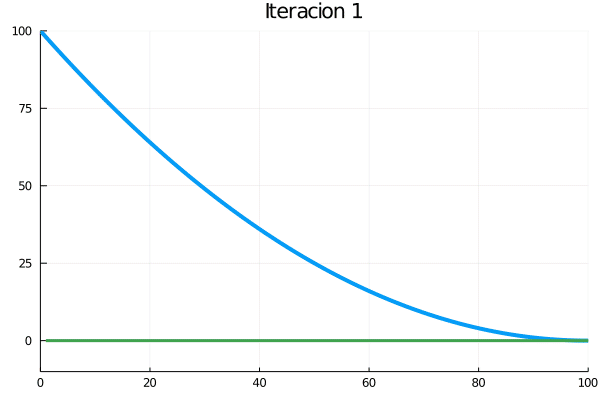

In [10]:
gif(anim,"tmp4.gif",fps=20)

### Resuelvo el problema de stock.

In [6]:
#resuelvo una vez mas para hallar el costo optimo
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)))

@variable(model,reserve>=0);
@variable(model,stock>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
end

fix_x = @constraint(model,stock==x0);

@objective(model,Min,p*reserve+z);

optimize!(model)

x=value(stock)+value(reserve);
costo = objective_value(model);

Optimize a model with 202 rows, 3 columns and 558 nonzeros
Coefficient statistics:
  Matrix range     [4e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+02]
Presolve removed 1 rows and 24 columns
Presolve time: 0.00s
Presolved: 2 rows, 178 columns, 356 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.639066e+04      0s
      13    8.8215079e+01   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.00 seconds
Optimal objective  8.821507908e+01


In [7]:
x

83.18804071504196

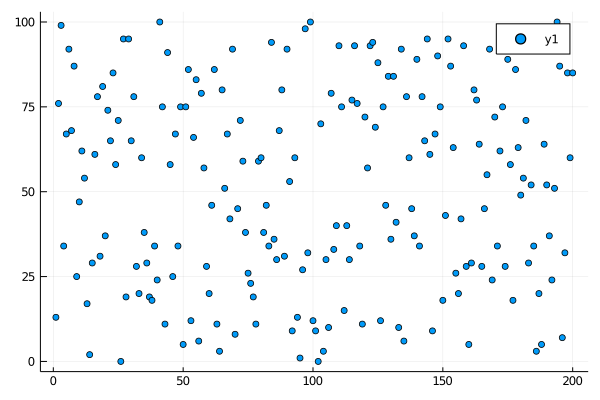

In [8]:
scatter(explored_states)